In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set figure parameters for all plots
newParams = {'figure.figsize'  : (12, 6),  # Figure size
             'figure.dpi'      : 200,      # figure resolution
             'axes.titlesize'  : 20,       # fontsize of title
             'axes.labelsize'  : 11,       # fontsize of axes labels
             'axes.linewidth'  : 2,        # width of the figure box lines
             'lines.linewidth' : 1,        # width of the plotted lines
             'savefig.dpi'     : 200,      # resolution of a figured saved using plt.savefig(filename)
             'ytick.labelsize' : 11,       # fontsize of tick labels on y axis
             'xtick.labelsize' : 11,       # fontsize of tick labels on x axis
             'legend.fontsize' : 12,       # fontsize of labels in legend
             'legend.frameon'  : True,     # activate frame on lengend?
            }
plt.rcParams.update(newParams) # Set new plotting parameters

In [3]:
# Implementing the drag function
def drag(v_):
  """
  Function that incorporates a quadratic term as a drag
  Parameters
  ----------
  v_ : Float
        Value of v
  g : Float
        Value of g
  """
  return  gamma*np.square(v_) - g 

# Implementing of Euler Solver
def euler_drag(f,t0: float,tN: float, N: int)->tuple:
      """
      Euler Implementation:
      Parameters
      ----------
      f : Function
            Quadradic drag function
      t0 : Float
            Initial time
      tN : Float
            Final time
      N : Integer
            Number of steps
      """
      t = np.linspace(t0, tN, N)
      v    = np.zeros([N])
      y    = np.zeros([N])
      h = (tN-t0)/N
      for i in range(1,N):
            v[i] = v[i-1] + h*f(v[i-1])
            y[i] = y[i-1] + h*v[i]
      return t, y, v

# Implementing Runge-Kutta Solver
def rk4_drag(f,t0,tN, N):
  """
  Runge-Kutta Implementation:
  Parameters
  ----------
  f : Function
        Quadradic drag function

  t0 : Float
        Initial time
  tN : Float
        Final time
  N : Integer
        Number of steps
  """
  t = np.linspace(t0, tN, N)
  v = np.zeros(N)
  y = np.zeros(N)
  h = (tN-t0)/N
  for n in range(1,N):
    k1 = h*f(v[n-1]       )
    k2 = h*f(v[n-1] + k1/2)
    k3 = h*f(v[n-1] + k2/2)
    k4 = h*f(v[n-1] + k3  )

    v[n] = v[n-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    y[n] = y[n-1] + v[n]*h
  return t, y, v

def adaptive_drag(f, t0:float, tN:float, h_initial:float, eps=1e-3, h_min=1e-4, h_max=1.0) -> tuple:
      """
      Adaptive step size Runge-Kutta solver for a first order ODE
      Parameters
      ----------
      f : Function
              Quadradic drag function
      t0 : Float
              Initial time
      tN : Float
                  Final time
      h_initial : Float
                  Initial step size
      eps : Float
                  Error tolerance
      h_min : Float
                  Minimum step size
      h_max : Float
                  Maximum step size
      """
      t = [t0]
      v = [0]  # Initial condition v(t0) = 0
      y = [0]  # Initial condition y(t0) = 0
      h = h_initial
      while t[-1] < tN:
            v_current = v[-1]
            t_current = t[-1]

            # Midpoint Rule (2nd order RK)
            k1 = f(v_current)
            k2 = f(v_current + h/2 * k1)
            v_next = v_current + h * k2

            # Error Estimation (using embedded Euler step)
            v_euler = v_current + h * k1  # Simple Euler step
            error = abs(v_next - v_euler)

            # Step Size Adjustment
            if error < eps:
                  t.append(t_current + h)
                  v.append(v_next)
                  y.append(y[-1] + v_next*h) # Updating y position
                  h = min(h * 1.2, h_max)  # Increase step size slightly
            else:
                  h = max(h * 0.5, h_min)  # Decrease step size

            # if h < h_min:
            #     raise ValueError("Step size too small. Consider reducing tolerance or increasing h_min.")

      return np.array(t), np.array(y), np.array(v)

In [4]:
# Retrieve Experimental Data
tdata,xdata,ydata,vxdata,vydata = np.loadtxt("tennis1.txt", unpack=True)

# Normalize data
tdata  = tdata-tdata[0]
xdata  = -(xdata-xdata[0])
vxdata = vxdata-vxdata[0]

# Error bands for trial1
xdata_upr = xdata + .03
xdata_lwr = xdata - .03

In [5]:
# Define Global Parameters
g     = 9.8                       # gravity
c_d   = .6                        # cd of tennis ball
rho   = 1.                        # density
area  = 3.25*10**-3               # cross sectional area of tennis ball in m^2
mass  = 58 *10**-3                # mass of tennis ball in kg
gamma = .5*(1/mass)*rho*area*c_d  # drag coefficient
# gamma = 0.0005
# Time interval
t0 = 0.00
tf = 0.44

# Number of steps
N  = 50

In [6]:
print(gamma)

0.016810344827586206


In [7]:
# Euler Solution
euler_solver = euler_drag(drag, t0, tf, N)

In [8]:
# Runge-Kutta Solution
rk4_solver = rk4_drag(drag,t0,tf, N)

In [9]:
# Adaptative Step Size Solution
h_initial = 0.1 #initial step size
adapt_solver = adaptive_drag(drag, t0, tf, h_initial)

In [10]:
pinn_data = np.loadtxt('pinn_data.txt', delimiter=',', skiprows=1)  # Load saved data

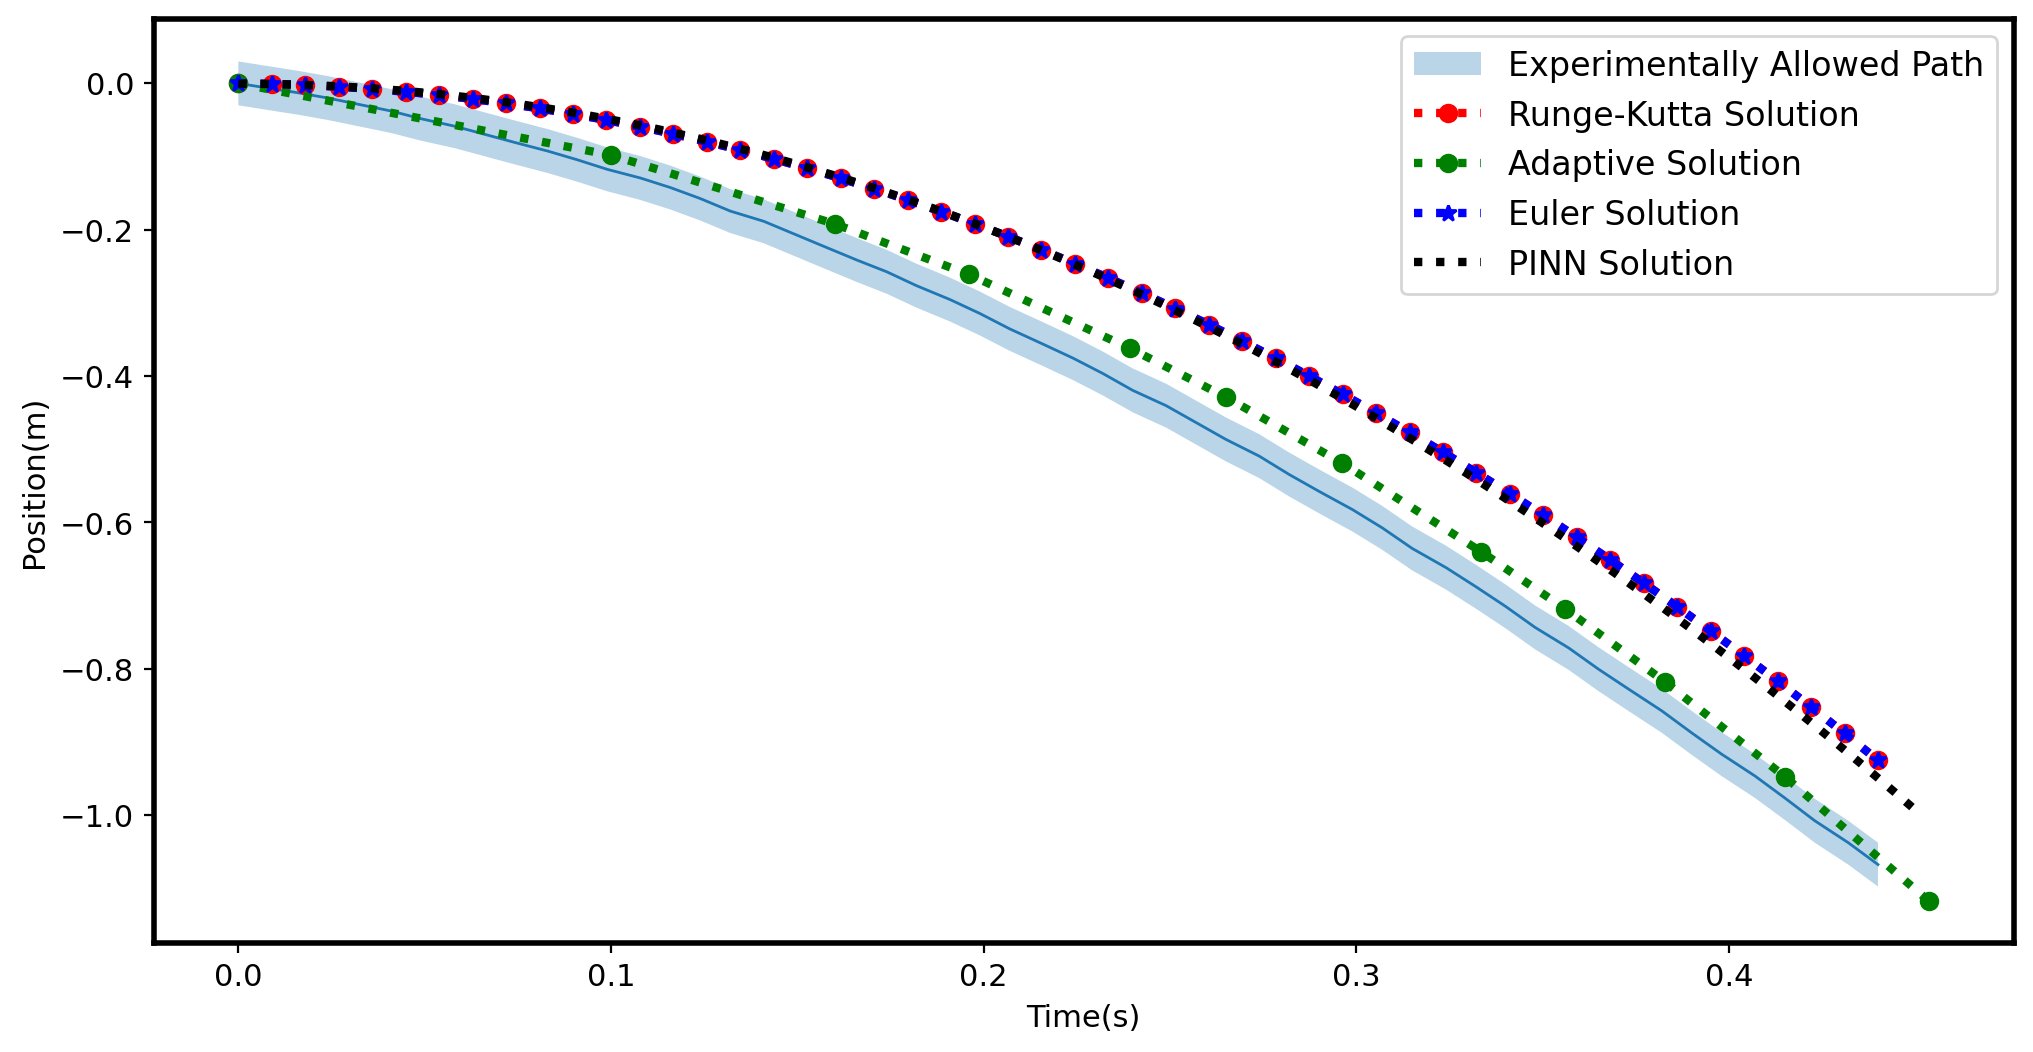

In [11]:
plt.plot(tdata,xdata)
plt.fill_between(tdata, xdata_upr, xdata_lwr,    alpha=0.3,    label="Experimentally Allowed Path")
plt.plot(rk4_solver[0],rk4_solver[1],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
plt.plot(adapt_solver[0],adapt_solver[1],':go' , linewidth=3.0,label=r'Adaptive Solution')
plt.plot(euler_solver[0],euler_solver[1],':b*' , linewidth=3.0,label=r'Euler Solution')
plt.plot(pinn_data[:,0],-pinn_data[:,1],':k' , linewidth=3.0,label=r'PINN Solution')
plt.xlabel('Time(s)')
plt.ylabel('Position(m)')
plt.legend()
plt.show()

In [14]:
# plt.plot(rk4_solver[0],rk4_solver[1],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
# plt.plot(adapt_solver[0],adapt_solver[1],':go' , linewidth=3.0,label=r'Adaptive Solution')
# plt.plot(euler_solver[0],euler_solver[1],':b*' , linewidth=3.0,label=r'Euler Solution')

data = np.column_stack((euler_solver[0],euler_solver[1]))
np.savetxt('euler_solver.csv', data, delimiter=',', header='x,y')